## PokerNow: Data Wrangling and EDA

This notebook will look through the analysis of log files from a typical PokerNow session with my friends.

During the lockdown, PokerNow naturally became a go-to platform for my friends and I to gather online and banter. On top of this, I enjoy the analytical and statistical elements of the game, which is complemented nicely by the psychological warfare, making for a perfect tactical game to test your wits amongst friends.

Needless to say, this analysis was a lot of fun to make, as it coincided with my interests in both poker and data. 
The intended result was to gain a deeper insight into how each player played, rather than simply gauging off of win/loss amounts.

(Credits to PokerNow, for providing a free and easy-to-setup platform, with exportable data logs: https://www.pokernow.club/)


**Challenges:**
The biggest challenge was the ETL / data-cleaning, which is needed to turn the data from a "raw" format to a structured dataset, and to feature engineer new data points.


In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = 100
from datetime import datetime, timedelta
os.getcwd()
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'figure.autolayout': True})
pd.options.display.float_format = "{:,.2f}".format
plt.gcf().subplots_adjust(bottom=0.15)
import numpy as np


<Figure size 1080x720 with 0 Axes>

In [2]:
# Read in the PokerNow log file
df = pd.read_csv("logs/poker_now_log_xRTMZq3zpWgFnJWvQvNiciq18.csv")

In [3]:
df.head()

,entry,at,order
0,"The player ""scott @ Ng7stAYDQy"" stand up with ...",2020-10-03T09:04:13.235Z,160171585323601
1,"The player ""AAron @ SgIZePqJyI"" stand up with ...",2020-10-03T09:04:13.235Z,160171585323600
2,-- ending hand #199 --,2020-10-03T09:04:10.323Z,160171585032402
3,"""Joe @ 4KATp5caOw"" collected 10 from pot",2020-10-03T09:04:10.323Z,160171585032401
4,"Uncalled bet of 5 returned to ""Joe @ 4KATp5caOw""",2020-10-03T09:04:10.323Z,160171585032400


In [5]:
# Adding a "game" field if we add additional logs to the dataset in the future
df["game"] = "10-03"
del df['order']
df.columns=["action","time","game"]
df.head()

,action,time,game
0,"The player ""scott @ Ng7stAYDQy"" stand up with ...",2020-10-03T09:04:13.235Z,10-03
1,"The player ""AAron @ SgIZePqJyI"" stand up with ...",2020-10-03T09:04:13.235Z,10-03
2,-- ending hand #199 --,2020-10-03T09:04:10.323Z,10-03
3,"""Joe @ 4KATp5caOw"" collected 10 from pot",2020-10-03T09:04:10.323Z,10-03
4,"Uncalled bet of 5 returned to ""Joe @ 4KATp5caOw""",2020-10-03T09:04:10.323Z,10-03


In [6]:
#Adding the correctly formatted datetime, date, time fields
def datetime(row):
    return row["time"][:10] + "-" + row["time"][11:19]
def daterow(row):
    return row["time"][:10]
def timerow(row):
    return row["time"][11:19]

df["datetime"] = df.apply(lambda row: datetime(row), axis=1)
df['date'] = df.apply (lambda row: daterow(row), axis=1)
df["time"] = df.apply(lambda row: timerow(row), axis=1)

df.head()

,action,time,game,datetime,date
0,"The player ""scott @ Ng7stAYDQy"" stand up with ...",09:04:13,10-03,2020-10-03-09:04:13,2020-10-03
1,"The player ""AAron @ SgIZePqJyI"" stand up with ...",09:04:13,10-03,2020-10-03-09:04:13,2020-10-03
2,-- ending hand #199 --,09:04:10,10-03,2020-10-03-09:04:10,2020-10-03
3,"""Joe @ 4KATp5caOw"" collected 10 from pot",09:04:10,10-03,2020-10-03-09:04:10,2020-10-03
4,"Uncalled bet of 5 returned to ""Joe @ 4KATp5caOw""",09:04:10,10-03,2020-10-03-09:04:10,2020-10-03


In [8]:
#Creating a new dataframe "stacks" to analyze stack sizes later on
stacks = df[df['action'].str.contains("stacks")]
stacks = stacks.reset_index()
stacks.drop("index", axis=1, inplace=True)
stacks.head()

,action,time,game,datetime,date
0,"Player stacks: #1 ""AAron @ SgIZePqJyI"" (2091) ...",09:04:05,10-03,2020-10-03-09:04:05,2020-10-03
1,"Player stacks: #1 ""AAron @ SgIZePqJyI"" (2151) ...",09:02:19,10-03,2020-10-03-09:02:19,2020-10-03
2,"Player stacks: #1 ""AAron @ SgIZePqJyI"" (2461) ...",09:00:45,10-03,2020-10-03-09:00:45,2020-10-03
3,"Player stacks: #1 ""AAron @ SgIZePqJyI"" (2491) ...",08:59:38,10-03,2020-10-03-08:59:38,2020-10-03
4,"Player stacks: #1 ""AAron @ SgIZePqJyI"" (2601) ...",08:57:47,10-03,2020-10-03-08:57:47,2020-10-03


In [13]:
# Create df2, which tracks each player's stacks over time
data=[]

for i in range(len(stacks)):
#     try:
    for j in stacks["action"][i].split("|"):
        name = j.split('"')[1].split("@")[0].strip(" ")
        stack_size = float(j.split('"')[2].strip(" (").strip(") "))
        time = stacks["time"][i]
        date = stacks["date"][i]
        datetime = stacks["datetime"][i]
        data.append([name,stack_size,time,date,datetime])

df2 = pd.DataFrame(data,columns=["Player","Stack","Time","Date","Date Time"])
df2.head(10)

,Player,Stack,Time,Date,Date Time
0,AAron,"2,091.00",09:04:05,2020-10-03,2020-10-03-09:04:05
1,Joe,"7,981.00",09:04:05,2020-10-03,2020-10-03-09:04:05
2,scott,"3,170.00",09:04:05,2020-10-03,2020-10-03-09:04:05
3,AAron,"2,151.00",09:02:19,2020-10-03,2020-10-03-09:02:19
4,Joe,"7,981.00",09:02:19,2020-10-03,2020-10-03-09:02:19
5,Jamz,"4,807.00",09:02:19,2020-10-03,2020-10-03-09:02:19
6,Ethan,"3,541.00",09:02:19,2020-10-03,2020-10-03-09:02:19
7,scott,"3,230.00",09:02:19,2020-10-03,2020-10-03-09:02:19
8,AAron,"2,461.00",09:00:45,2020-10-03,2020-10-03-09:00:45
9,Joe,"7,981.00",09:00:45,2020-10-03,2020-10-03-09:00:45


In [15]:
# The list of players during this session
df2["Player"].unique()

array(['AAron', 'Joe', 'scott', 'Jamz', 'Ethan', 'Steven', 'meesh',
       'andy', 'cyn', 'Andrew', 'Cyn', 'Caleb', 'Walter', 'Kwis', 'JAMZ'],
      dtype=object)

In [20]:
# Checking the data types and look for null values
df2.info()
df2.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     1583 non-null   object 
 1   Stack      1583 non-null   float64
 2   Time       1583 non-null   object 
 3   Date       1583 non-null   object 
 4   Date Time  1583 non-null   object 
dtypes: float64(1), object(4)
memory usage: 62.0+ KB


Player       0
Stack        0
Time         0
Date         0
Date Time    0
dtype: int64

In [21]:
df2.shape

(1583, 5)

# Looking at Stack Size Patterns for each Player

<AxesSubplot:xlabel='Time'>

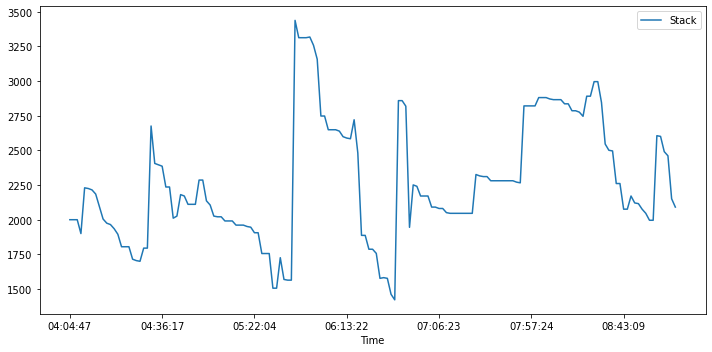

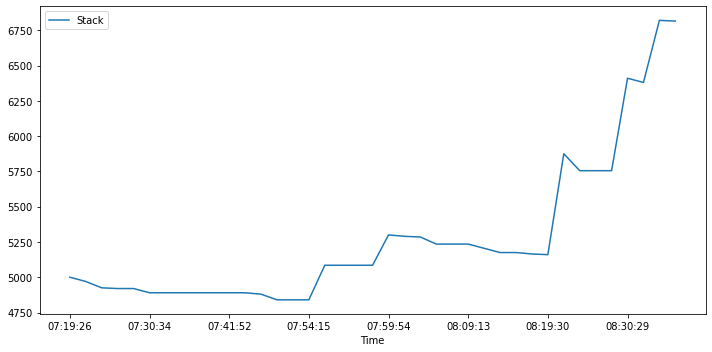

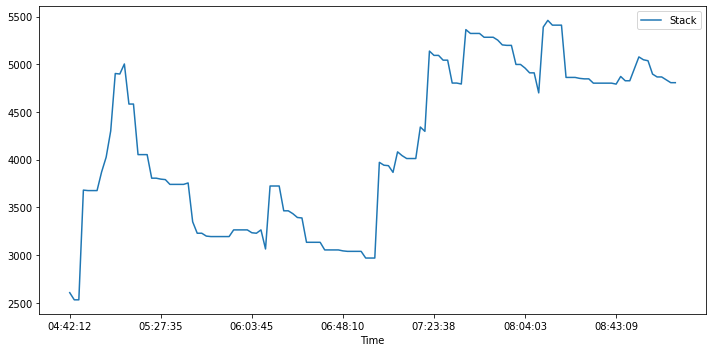

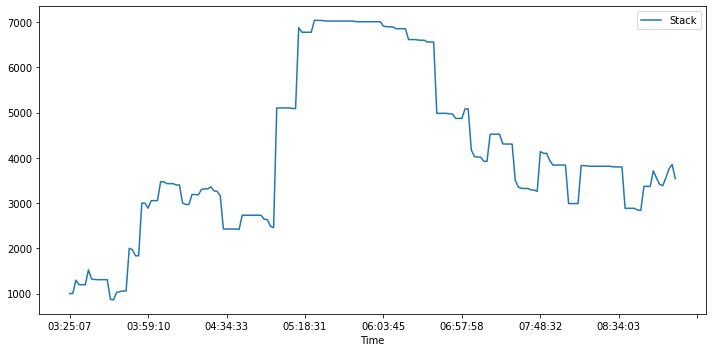

In [23]:
# Stack size trend lines for 4 individual players. 
# Note the direct upwards line in the first chart correlates to buy-in's, which was not factored out in this chart.
plt.rcParams["figure.figsize"] = (10,5)
df2[(df2["Player"].str.contains("AAron")) ].sort_values(ascending=True,by = "Time")\
    .plot(x="Time",y="Stack")
df2[(df2["Player"].str.contains("andy")) ].sort_values(ascending=True,by = "Time")\
    .plot(x="Time",y="Stack")
df2[(df2["Player"].str.contains("Jamz")) ].sort_values(ascending=True,by = "Time")\
    .plot(x="Time",y="Stack")
df2[(df2["Player"].str.contains("Ethan")) ].sort_values(ascending=True,by = "Time")\
    .plot(x="Time",y="Stack")



From the above, we can see the 2nd and 3rd player ended the night off with very large stacks, while the 4th player started slow, rised up high mid-game, and came back down to a middle-level at the end at around 4000 chips. The 1st player was up and down throughout the whole game, and looked to have made 2 buy-ins early on as well, which is not accounted for separately here.

In [28]:
# Using groupby to check the mean, max, min, std of each player's stacks.
# The "count" represents how many hands that player played. 

df2.groupby('Player').agg(['mean', 'max', 'min','std','count']).sort_values(by=("Stack","mean")\
    ,ascending=False)

Stack                                  
           mean       max      min      std count
Player                                           
Andrew 6,638.21 15,140.00   725.00 4,280.12   151
andy   5,275.13  6,820.00 4,840.00   533.70    39
Steven 4,994.23 12,031.00   164.00 2,983.70   180
scott  4,456.97  6,128.00 2,610.00 1,038.46    74
Joe    4,386.29  8,566.00   701.00 2,460.59   119
Jamz   4,158.15  5,460.00 2,531.00   839.34   134
Ethan  4,090.54  7,041.00   861.00 1,801.63   194
Caleb  2,642.01  5,745.00   911.00 1,511.67   129
AAron  2,265.12  3,438.00 1,422.00   437.60   165
JAMZ   2,244.25  3,309.00   995.00   745.90    44
Walter 2,242.62  3,439.00   831.00   795.87   103
Kwis   2,072.83  5,206.00   712.00 1,199.79   119
Cyn    2,000.00  2,000.00 2,000.00      NaN     1
cyn    1,965.00  2,000.00 1,945.00    20.21    13
meesh  1,898.99  3,811.00   163.00 1,009.06   118

Although this is just 1 session, we can "generally" attribute a smaller standard deviation with a safer or more conservative play-style, while high variance correlates with more risky play.

Do note once again that this graph does not take into account buy-in's, which would increase the stack size without winning a pot.

For this session, you can see I was smack in the middle in terms of mean stack size (2,265 chips), and my standard dev was also on the lower end.

[Text(1, 0, 'AAron'),
 Text(2, 0, 'Andrew'),
 Text(3, 0, 'Caleb'),
 Text(4, 0, 'Cyn'),
 Text(5, 0, 'Ethan'),
 Text(6, 0, 'JAMZ'),
 Text(7, 0, 'Jamz'),
 Text(8, 0, 'Joe'),
 Text(9, 0, 'Kwis'),
 Text(10, 0, 'Steven'),
 Text(11, 0, 'Walter'),
 Text(12, 0, 'andy'),
 Text(13, 0, 'cyn'),
 Text(14, 0, 'meesh'),
 Text(15, 0, 'scott')]

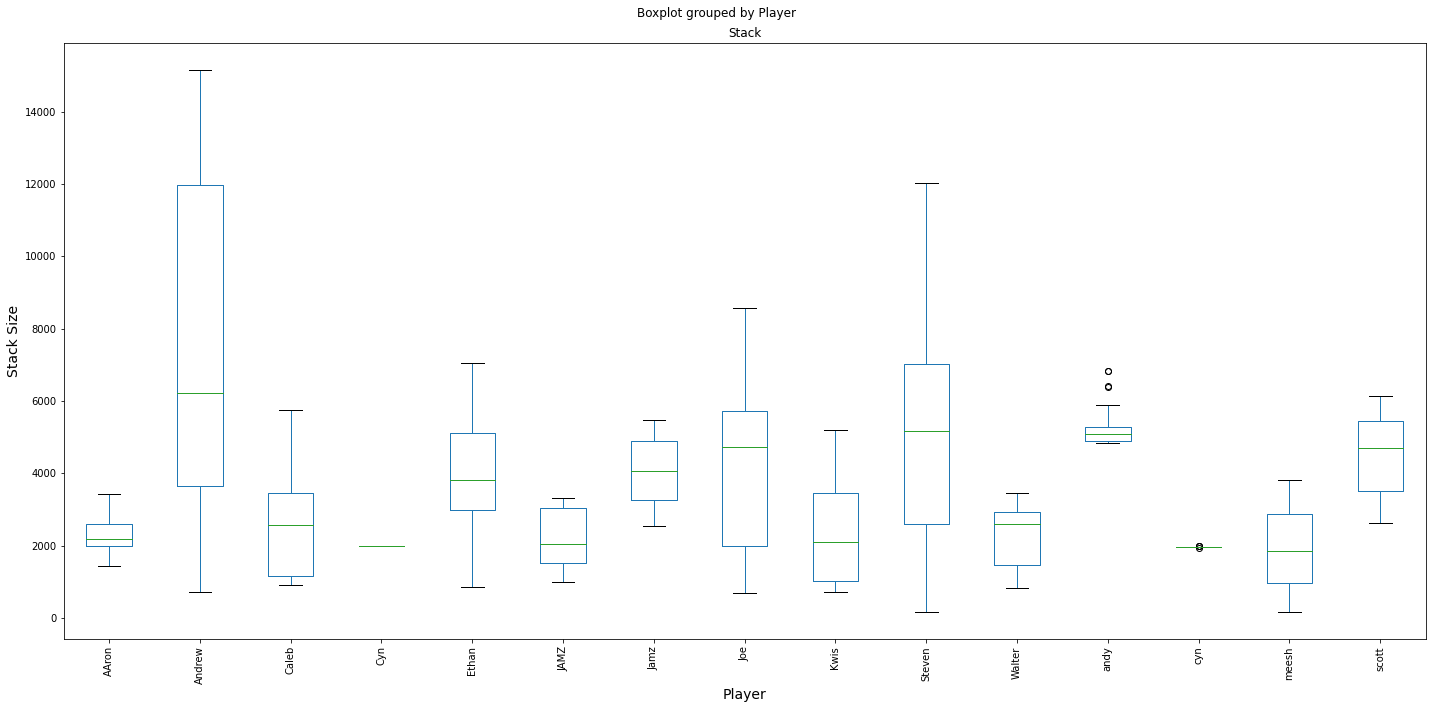

In [36]:
# Another way to visualize the mean, min, max, std of each player's stack sizes, using Box Plots.

bplot = df2.boxplot(by='Player', 
                       column=['Stack'], 
                       grid=False, )
# bplot.axes.set_title("Mean Stack Size / Variance by Player",
#                     fontsize=16)
bplot.set_xlabel("Player", 
                fontsize=14)
bplot.set_ylabel("Stack Size",
                fontsize=14)
bplot.tick_params(labelsize=10)
plt.rcParams["figure.figsize"] = (10,10)
bplot.set_xticklabels(bplot.get_xticklabels(),rotation=90)

Andrew, Steven, Joe, and Ethan had the largest variation / range during this session.

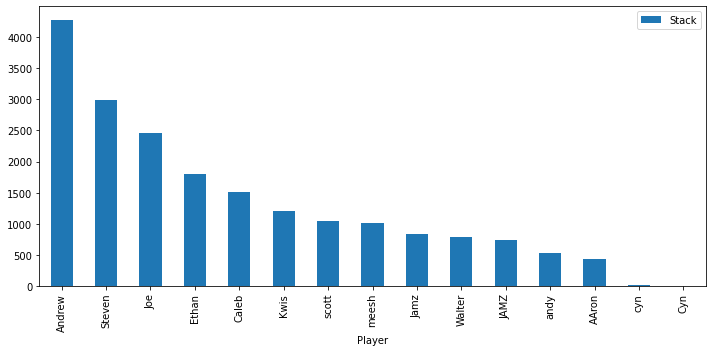

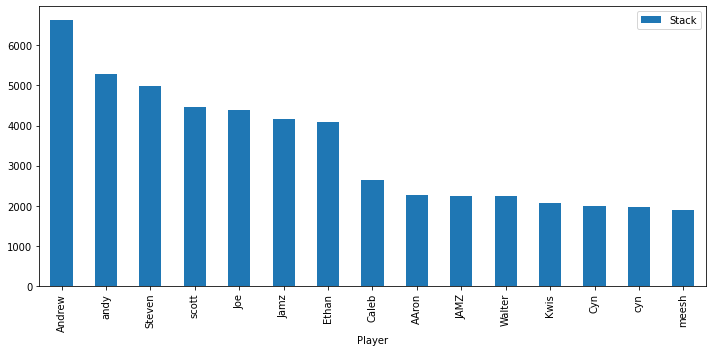

In [42]:
# Visualizing Mean and Std of stack sizes with bar charts:

plt.rcParams["figure.figsize"] = (10,5)
sample_plot = df2.groupby("Player").std().sort_values(ascending=False, by="Stack").plot(kind="bar")
sample_plot2 = df2.groupby("Player").mean().sort_values(ascending=False, by="Stack").plot(kind="bar")

Currently, seeing stack patterns for 1 session is not all that interesting (except seeing who won/lost on that particular day.. *cough me..).

However, repeating the exercise for multiple sessions, with multiple log files, would be interesting, as we could start to see patterns emerge, and whether certain player's win was a "fluke" or not.

# Calculating Win % and Win Types


In [52]:
df = pd.read_csv("logs/poker_now_log_x344T-q5owinwDl8lx7dS9Jpy.csv")
df.columns = ['action', 'time','order']
df = df.reindex(index=df.index[::-1])  # flip the df upside down for chronological order
df.head()

,action,time,order
5128,"The player ""Steven @ GWM99dqAoi"" created the g...",2020-10-01T02:11:49.833Z,160151830983800
5127,"The player ""andy @ x1ssluuc4S"" requested a seat.",2020-10-01T02:14:38.769Z,160151847877000
5126,"The admin approved the player ""andy @ x1ssluuc...",2020-10-01T02:14:49.503Z,160151848950600
5125,The game's big blind was changed from 10 to 5.,2020-10-01T02:14:56.053Z,160151849605400
5124,The game's small blind was changed from 20 to 10.,2020-10-01T02:14:56.053Z,160151849605401


In [45]:
# We need to flip the dataframe 'upside down' for chronological order
df = df.reindex(index=df.index[::-1])  
df.head()

,action,time,game,datetime,date
5513,"The player ""Steven @ GWM99dqAoi"" created the g...",01:48:45,10-03,2020-10-03-01:48:45,2020-10-03
5512,"The player ""Kwis @ 1YCO6xRgZF"" requested a seat.",01:49:25,10-03,2020-10-03-01:49:25,2020-10-03
5511,"The admin approved the player ""Kwis @ 1YCO6xRg...",01:49:55,10-03,2020-10-03-01:49:55,2020-10-03
5510,"The player ""Kwis @ 1YCO6xRgZF"" stand up with t...",02:08:25,10-03,2020-10-03-02:08:25,2020-10-03
5509,"The player ""Jamz @ Xg6uSZZOvr"" requested a seat.",03:10:25,10-03,2020-10-03-03:10:25,2020-10-03


## Data engineering

We need to create a new Dataframe with all the new interested features, such as Winner, Hand Type, Action taken, Position, and # of players in hand.

For this, we need to categorize the "types of rows" that are currently in the raw log file in a useful way in which we can extract info from. 

After studying the log file, we can group them into the following **"Row Types"**:
* **Starting Hand:**
    * eg. "starting hand #150  (No Limit Texas Hold'em) (dealer: "AAron @ SgIZePqJyI") --"
    * contains Dealer, Hand #
* **Player Stacks:**
    * eg. "Player stacks: #2 "Ayush @ _e74w1sbtZ" (3298) | #3 "Jamz @ Xg6uSZZOvr" (3048) | #6 "Ethan @ w1_Hje3yn2" (13791) | #7 "Justin @ _g_OqsZX-M" (5600) | #8 "AAron @ SgIZePqJyI" (2302) | #9 "meesh @ He9325iWeJ" (3592) | #10 "Steven @ GWM99dqAoi" (3842)"
    * contains stack sizes at the start of each hand & absolute player seating position
* **Player Actions:**
    * eg. "AAron @ SgIZePqJyI" calls 40"
    * contains player action types and bet sizes
* **Win Details:**
    * eg. "AAron @ SgIZePqJyI" collected 2302 from pot with Royal Flush (combination: A‚ô£, K‚ô£, Q‚ô£, J‚ô£, 10‚ô£)
    * contains Winner, whether hand was showdown/non-showdown, hand details, hand type and win amount.
    
After this, we just need to figure out the "unique" words that appear in each Row Type, and create new columns with extracted data.

In [58]:
data=[]
h=0
j=0
n = 0

substring_list = ["posts","folds","raises","calls","bets","checks", "collected"]    # All possible player actions

# For each row in Dataframe
for i in range(len(df)):   
    a = df.iloc[i]["action"]    # Action string
    b = df["time"].iloc[i]      # Time
    
    #Row Type: Starting Hand - contains dealer, hand #
    if "starting hand" in df.iloc[i]["action"]:   
        h = int(df.iloc[i]["action"].split("starting hand #")[1].split(" (")[0].strip(" "))    #Hand Number
        try:
            j = df.iloc[i]["action"].split('dealer: "')[1].split(" @")[0].strip(" ")    # Dealer for this hand
        except IndexError:
            j = "N/A"     #Sometimes no dealer
            
    else:      #  unnecessary?
        pass
    
    # Row Type: Player Stacks - contains stack sizes & absolute player seating position
    if "Player stacks" in df.iloc[i]["action"]:    
        position = 1
        order = {}    # Dictionary of players and hand position
        for J in df.iloc[i]["action"].split("|"): 
            Player = J.split('"')[1].split("@")[0].strip(" ")
            order[Player] = position    # Filling up dict
            position += 1  
            
    o = len(order)      # Number of players in hand
    
    # Row Type: Player Actions - contains player name, action, bet sizes
    if any(substring in df.iloc[i]["action"] for substring in substring_list):   
        k = df.iloc[i]["action"].split('@')[0].strip('"').strip(" ")       # Player name
        l = df.iloc[i]["action"].split('"')[2].strip(" ").split(" ")[0]    # Player action. Eg. bets, raises, folds
        m = order[k]   # Abs player seating pos
        if j != "N/A":    # j = Dealer. Find relative player position to Dealer (eg. 0 = dealer, 1 = small blind.. etc.)
            try:
                if order[k] > order[j]:
                    n = int(order[k] - order[j])   
                else:
                    n = int(order[k] + len(order) - order[j])
            except KeyError:
                n=0
        else:
            n = 0
        
    else:
        k = "N/A"
        l = "N/A"
        m = "N/A"
        n = 0
    
    # Row Type: Win details - contains Winner, showdown/non-showdown, hand details, hand type and win amount.
    if "collected" in df.iloc[i]["action"]:   
        d = float(df.iloc[i]["action"].split("collected ")[1].split(" from pot")[0])    # Win Amount
        c = df.iloc[i]["action"].split(" @")[0].strip('"')    # Winner of hand
        try:
            e = df.iloc[i]["action"].split("from pot with ")[1]    #Full Hand details - eg. Straight, 8 High (combination: 8♣, 7♣, 6♦, 5♣, 4♥)
            f = df.iloc[i]["action"].split("from pot with ")[1].split(",")[0]   #Hand Type - eg. Straight
            if "High" in f:
                f = "High Card"
        except IndexError:
            e = "Non-Showdown"
            f = "Non-Showdown"                           
        g = len(df)-i   # Row sequence #
    else:    # if Row type != Win details
        c = "N/A"
        d = 0
        e = "N/A"
        f = "N/A"
        g = "N/A"
    
    data.append([a,b,c,d,e,f,g,h,j,k,l,m,n,o])
    
data
new_df = pd.DataFrame(data, columns=["Full Text","Time", "Winner","Pot","Hand","Hand Type","Action Sequence Number",\
                                     "Hand Number","Dealer","Player","Action","Absolute Position", \
                                     "Relative Position to Dealer", "# of Players"])

new_df.tail(10)

,Full Text,Time,Winner,Pot,Hand,Hand Type,Action Sequence Number,Hand Number,Dealer,Player,Action,Absolute Position,Relative Position to Dealer,# of Players
5119,"""meesh @ He9325iWeJ"" checks",2020-10-01T07:04:42.297Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,meesh,checks,5,2,5
5120,"""Jamz @ Xg6uSZZOvr"" checks",2020-10-01T07:04:47.579Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,Jamz,checks,1,3,5
5121,"river: K♥, 4♠, 3♣, 6♥ [7♠]",2020-10-01T07:04:48.384Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,N/A,N/A,N/A,0,5
5122,"""meesh @ He9325iWeJ"" bets 150",2020-10-01T07:04:52.572Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,meesh,bets,5,2,5
5123,"""Jamz @ Xg6uSZZOvr"" raises to 300",2020-10-01T07:04:54.766Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,Jamz,raises,1,3,5
5124,"""meesh @ He9325iWeJ"" calls 300",2020-10-01T07:04:58.849Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,meesh,calls,5,2,5
5125,"""Jamz @ Xg6uSZZOvr"" shows a 5♥, A♣.",2020-10-01T07:04:59.657Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,N/A,N/A,N/A,0,5
5126,"""Jamz @ Xg6uSZZOvr"" collected 905 from pot wit...",2020-10-01T07:04:59.657Z,Jamz,905.00,"Straight, 7 High (combination: 7♠, 6♥, 5♥, 4♠,...",Straight,3,213,Ayush,Jamz,collected,1,3,5
5127,-- ending hand #213 --,2020-10-01T07:04:59.657Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,N/A,N/A,N/A,0,5
5128,"""Ayush @ _e74w1sbtZ"" shows a 10♠, 5♠.",2020-10-01T07:05:00.809Z,N/A,0.00,N/A,N/A,N/A,213,Ayush,N/A,N/A,N/A,0,5


With this new dataframe, we now have a play-by-play log of every hand, in a structured format.

Notice that many fields like "Pot", "Hand", "Hand Type" and "Winner" only show up on rows that show the win details. Otherwise, they will be shown as "N/A".

## EDA

In [60]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5129 entries, 0 to 5128
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Full Text                    5129 non-null   object 
 1   Time                         5129 non-null   object 
 2   Winner                       5129 non-null   object 
 3   Pot                          5129 non-null   float64
 4   Hand                         5129 non-null   object 
 5   Hand Type                    5129 non-null   object 
 6   Action Sequence Number       5129 non-null   object 
 7   Hand Number                  5129 non-null   int64  
 8   Dealer                       5129 non-null   object 
 9   Player                       5129 non-null   object 
 10  Action                       5129 non-null   object 
 11  Absolute Position            5129 non-null   object 
 12  Relative Position to Dealer  5129 non-null   int64  
 13  # of Players      

In [61]:
new_df.groupby("Winner").mean().drop("Hand Number", axis=1).sort_values(by="Pot",ascending=False)

,Pot,Relative Position to Dealer,# of Players
Winner,,,
andy,"1,251.53",4.59,6.97
Ethan,"1,223.63",4.37,6.80
Andrew,"1,145.00",4.62,7.50
Ayush,895.53,3.33,7.07
Justin,849.87,4.22,6.52
AAron,807.29,4.43,7.00
Jamz,761.17,3.89,6.56
meesh,712.18,3.59,6.86
Steven,574.10,3.39,6.06


In [62]:
pivot1 = pd.pivot_table(new_df,index=["Winner"], columns=["Relative Position to Dealer"], values=["Pot"], aggfunc=[np.mean]\
                        ,margins=True)
pivot1

mean                                      \
                               Pot                                       
Relative Position to Dealer      0        1        2        3        4   
Winner                                                                   
AAron                          NaN 1,181.00   102.50    25.00      NaN   
Andrew                         NaN 1,310.00      NaN   160.00   530.00   
Ayush                          NaN 1,187.00 1,116.25   400.00   967.50   
Cal                         462.50   315.00   569.00   420.00 1,732.50   
Chris                          NaN      NaN   157.50      NaN      NaN   
Ethan                          NaN 1,138.00 1,214.67   516.00 2,640.00   
Jamz                           NaN   720.50   614.00   910.00      NaN   
Justin                         NaN   660.00   258.33   404.50   195.00   
N/A                           0.00     0.00     0.00     0.00     0.00   
Steven                       85.00   522.00   168.33 1,180.00   428.25   
andy                           NaN   143.33 1,534.17   875.00 1,542.33   
meesh                        90.00   655.00   996.67   647.50   132.50   
All                           0.67    32.86    43.17    24.41    49.82   

                                                                         \
                                                                          
Relative Position to Dealer        5        6        7      8         9   
Winner                                                                    
AAron                       1,155.00 1,093.75   435.00    NaN       NaN   
Andrew                      5,465.00   125.00      NaN 915.00       NaN   
Ayush                         155.00   920.67      NaN    NaN       NaN   
Cal                           315.25   340.20   340.00  35.00       NaN   
Chris                            NaN      NaN      NaN    NaN       NaN   
Ethan                         168.00   605.00   946.80 315.33 10,131.00   
Jamz                          215.00 1,587.50 1,122.50 395.00       NaN   
Justin                      1,932.33   160.00 2,269.00    NaN       NaN   
N/A                             0.00     0.00     0.00   0.00      0.00   
Steven                        758.00   916.25 1,619.50    NaN       NaN   
andy                        3,615.00    93.33   940.00 211.25       NaN   
meesh                         930.67 1,507.00   641.00  25.00       NaN   
All                            89.51    56.02    93.59  34.74    422.12   

                                      
                                      
Relative Position to Dealer      All  
Winner                                
AAron                         807.29  
Andrew                      1,145.00  
Ayush                         895.53  
Cal                           491.89  
Chris                         157.50  
Ethan                       1,223.63  
Jamz                          761.17  
Justin                        849.87  
N/A                             0.00  
Steven                        574.10  
andy                        1,251.53  
meesh                         712.18  
All                            36.46

## Calculating Win Percentage

In [63]:
wins = df[df['action'].str.contains("collect")]
wins = wins.reset_index()
wins.drop("index", axis=1, inplace=True)
wins

,action,time,order
0,"""Ethan @ w1_Hje3yn2"" collected 70 from pot",2020-10-01T02:35:38.633Z,160151973863401
1,"""Steven @ GWM99dqAoi"" collected 65 from pot",2020-10-01T02:36:07.685Z,160151976768601
2,"""andy @ x1ssluuc4S"" collected 10 from pot",2020-10-01T02:36:17.455Z,160151977745601
3,"""Ethan @ w1_Hje3yn2"" collected 10 from pot",2020-10-01T02:36:26.633Z,160151978663301
4,"""andy @ x1ssluuc4S"" collected 25 from pot",2020-10-01T02:36:40.662Z,160151980066201
...,...,...,...
209,"""Jamz @ Xg6uSZZOvr"" collected 1820 from pot",2020-10-01T06:58:10.048Z,160153549004901
210,"""Steven @ GWM99dqAoi"" collected 360 from pot",2020-10-01T06:59:33.135Z,160153557313601
211,"""Jamz @ Xg6uSZZOvr"" collected 2960 from pot wi...",2020-10-01T07:01:46.091Z,160153570609300
212,"""Justin @ _g_OqsZX-M"" collected 70 from pot",2020-10-01T07:03:27.375Z,160153580737601


In [64]:
wins["action"].iloc[0]

'"Ethan @ w1_Hje3yn2" collected 70 from pot'

In [65]:

data=[]
for i in range(len(wins)):
#     print(wins.iloc[i]["action"].split(" @")[0].strip('"'))
    
    a = wins.iloc[i]["action"].split(" @")[0].strip('"')
    b = wins.iloc[i]["action"]
    c = wins["time"].iloc[i]
#     d = wins["game"].iloc[i]
#     e = wins["datetime"].iloc[i]
#     f = wins["date"].iloc[i]
    g = float(wins.iloc[i]["action"].split("collected ")[1].split(" from pot")[0])
    try:
        h = wins.iloc[i]["action"].split("from pot with ")[1]
    except IndexError:
        h = "Non-Showdown"
    if h != "Non-Showdown":
        I = wins.iloc[i]["action"].split("from pot with ")[1].split(",")[0]
    else:
        I = "Non-Showdown"
    if "High" in I:
            I = "High Card"
    else:
        I=I
    j = len(wins)-i
    data.append([b,c,a,g,h,I,j])
    
data
wins_df = pd.DataFrame(data, columns=["Action","Time", "Winner","Pot","Hand","Hand Type","Hand Number"])
# wins_df = pd.DataFrame(data, columns=["Action","Time","Game","Date Time","Date", "Winner","Pot","Hand","Hand Type","Hand Number"])

wins_df

,Action,Time,Winner,Pot,Hand,Hand Type,Hand Number
0,"""Ethan @ w1_Hje3yn2"" collected 70 from pot",2020-10-01T02:35:38.633Z,Ethan,70.00,Non-Showdown,Non-Showdown,214
1,"""Steven @ GWM99dqAoi"" collected 65 from pot",2020-10-01T02:36:07.685Z,Steven,65.00,Non-Showdown,Non-Showdown,213
2,"""andy @ x1ssluuc4S"" collected 10 from pot",2020-10-01T02:36:17.455Z,andy,10.00,Non-Showdown,Non-Showdown,212
3,"""Ethan @ w1_Hje3yn2"" collected 10 from pot",2020-10-01T02:36:26.633Z,Ethan,10.00,Non-Showdown,Non-Showdown,211
4,"""andy @ x1ssluuc4S"" collected 25 from pot",2020-10-01T02:36:40.662Z,andy,25.00,Non-Showdown,Non-Showdown,210
...,...,...,...,...,...,...,...
209,"""Jamz @ Xg6uSZZOvr"" collected 1820 from pot",2020-10-01T06:58:10.048Z,Jamz,"1,820.00",Non-Showdown,Non-Showdown,5
210,"""Steven @ GWM99dqAoi"" collected 360 from pot",2020-10-01T06:59:33.135Z,Steven,360.00,Non-Showdown,Non-Showdown,4
211,"""Jamz @ Xg6uSZZOvr"" collected 2960 from pot wi...",2020-10-01T07:01:46.091Z,Jamz,"2,960.00","Straight, 6 High (combination: 6♣, 5♣, 4♥, 3♣,...",Straight,3
212,"""Justin @ _g_OqsZX-M"" collected 70 from pot",2020-10-01T07:03:27.375Z,Justin,70.00,Non-Showdown,Non-Showdown,2


<AxesSubplot:xlabel='Winner'>

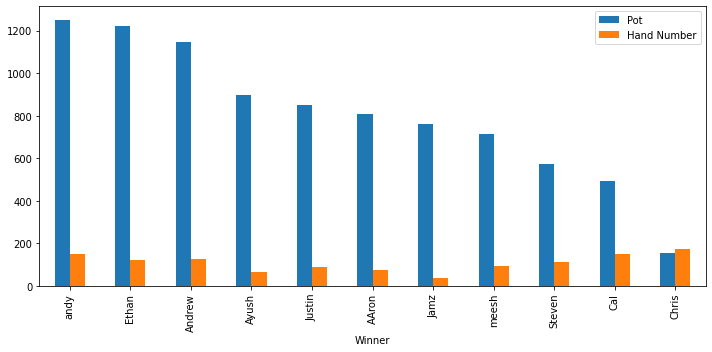

In [66]:
wins_df.groupby("Winner").mean().sort_values(ascending=False, by="Pot").plot(kind="bar")

In [67]:
wins_df[(wins_df["Hand"]!="Non-Showdown")]

,Action,Time,Winner,Pot,Hand,Hand Type,Hand Number
5,"""Steven @ GWM99dqAoi"" collected 540 from pot w...",2020-10-01T02:37:29.230Z,Steven,540.00,"Flush, Kd High (combination: K♦, 10♦, 7♦, 6♦, 5♦)",Flush,209
9,"""Chris @ 1YCO6xRgZF"" collected 135 from pot wi...",2020-10-01T02:41:18.915Z,Chris,135.00,"Pair, 7's (combination: 7♦, 7♠, A♣, K♣, Q♣)",Pair,205
10,"""Cal @ C1JUuMhLYL"" collected 761 from pot with...",2020-10-01T02:42:24.987Z,Cal,761.00,"Two Pair, J's & 3's (combination: J♥, J♠, 3♥, ...",Two Pair,204
12,"""Ethan @ w1_Hje3yn2"" collected 321 from pot wi...",2020-10-01T02:44:02.648Z,Ethan,321.00,"Pair, 9's (combination: 9♥, 9♦, A♣, J♠, 8♥)",Pair,202
14,"""Steven @ GWM99dqAoi"" collected 805 from pot w...",2020-10-01T02:46:30.381Z,Steven,805.00,"Two Pair, Q's & 8's (combination: Q♠, Q♦, 8♠, ...",Two Pair,200
15,"""Cal @ C1JUuMhLYL"" collected 365 from pot with...",2020-10-01T02:47:51.353Z,Cal,365.00,"Pair, K's (combination: K♠, K♥, Q♣, 10♥, 6♣)",Pair,199
27,"""andy @ x1ssluuc4S"" collected 165 from pot wit...",2020-10-01T02:56:52.147Z,andy,165.00,"Pair, 8's (combination: 8♦, 8♠, A♠, J♦, 7♣)",Pair,187
28,"""Steven @ GWM99dqAoi"" collected 510 from pot w...",2020-10-01T02:57:44.758Z,Steven,510.00,"Pair, A's (combination: A♦, A♠, K♠, J♥, 7♥)",Pair,186
29,"""Ethan @ w1_Hje3yn2"" collected 2932 from pot w...",2020-10-01T03:00:49.146Z,Ethan,"2,932.00","Four of a Kind, 8's (combination: 8♣, 8♠, 8♥, ...",Four of a Kind,185
31,"""andy @ x1ssluuc4S"" collected 1575 from pot wi...",2020-10-01T03:02:54.659Z,andy,"1,575.00","Three of a Kind, 9's (combination: 9♣, 9♥, 9♦,...",Three of a Kind,183


In [68]:
pd.pivot_table(wins_df,index=["Winner"],columns= ["Hand Type"], values=["Pot"], aggfunc=["mean"], fill_value=0)


mean                                                            \
               Pot                                                             
Hand Type    Flush Four of a Kind Full House High Card Non-Showdown     Pair   
Winner                                                                         
AAron     3,670.00              0          0         0       135.56 1,370.00   
Andrew    3,387.50              0          0         0       357.00     0.00   
Ayush     1,760.00              0          0         0       379.27     0.00   
Cal         560.00              0          0         0       457.43   540.33   
Chris         0.00              0          0         0       180.00   135.00   
Ethan       404.00           2932          0       180       565.67 3,535.00   
Jamz          0.00              0          0         0       524.62   643.00   
Justin    4,284.00              0          0      5511       272.37     0.00   
Steven      932.50              0          0         0       300.62 1,299.75   
andy          0.00              0          0       125       265.91 1,718.80   
meesh         0.00              0       2000         0       147.08   456.00   

                                                                          
                                                                          
Hand Type Royal Flush (combination: A♣ Straight Three of a Kind Two Pair  
Winner                                                                    
AAron                             2302        0            0.00     0.00  
Andrew                               0        0            0.00   600.00  
Ayush                                0        0        1,035.00 3,233.00  
Cal                                  0        0            0.00   761.00  
Chris                                0        0            0.00     0.00  
Ethan                                0        0        2,120.00 1,072.00  
Jamz                                 0     1865            0.00     0.00  
Justin                               0        0            0.00 2,288.50  
Steven                               0        0        1,180.00 1,080.00  
andy                                 0    12665        5,202.50 2,410.00  
meesh                                0        0        2,577.00   815.00

In [70]:
pivot = pd.pivot_table(wins_df[wins_df["Hand Type"]=="Non-Showdown"],index=["Winner", "Hand Type"],values=["Pot"],
               aggfunc=["count",np.mean], margins=True)
pivot
# result = pivot.sort_values(('Pot'), ascending=False)


,,count,mean
,,Pot,Pot
Winner,Hand Type,,
AAron,Non-Showdown,9,135.56
Andrew,Non-Showdown,5,357.00
Ayush,Non-Showdown,11,379.27
Cal,Non-Showdown,14,457.43
Chris,Non-Showdown,1,180.00
Ethan,Non-Showdown,18,565.67
Jamz,Non-Showdown,13,524.62
Justin,Non-Showdown,19,272.37


<AxesSubplot:>

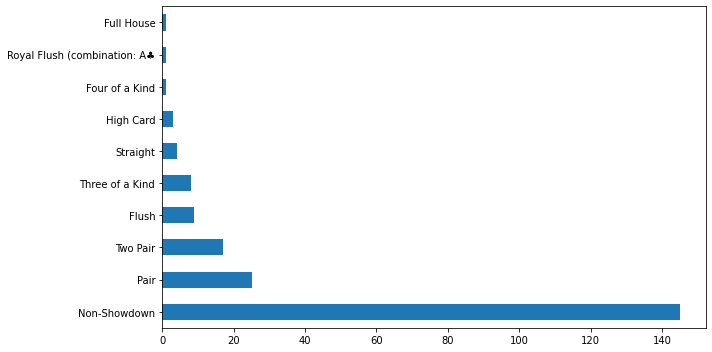

In [71]:
wins_df["Hand Type"].value_counts().plot(kind="barh")

## Individual Player Profiling

Here we pick a certain player (Eg. andy), to see what type of hands he generally likes to play, or wins with.

<AxesSubplot:>

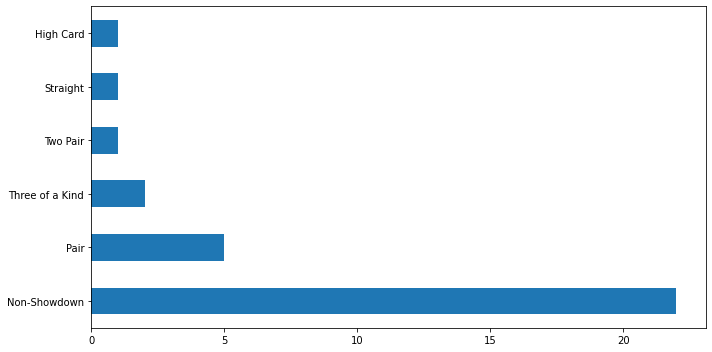

In [73]:
wins_df[wins_df["Winner"]=="andy"]["Hand Type"].value_counts().plot(kind="barh")

(-1.1135796449090427,
 1.1006466497575735,
 -1.1122519716333457,
 1.1086294480599852)

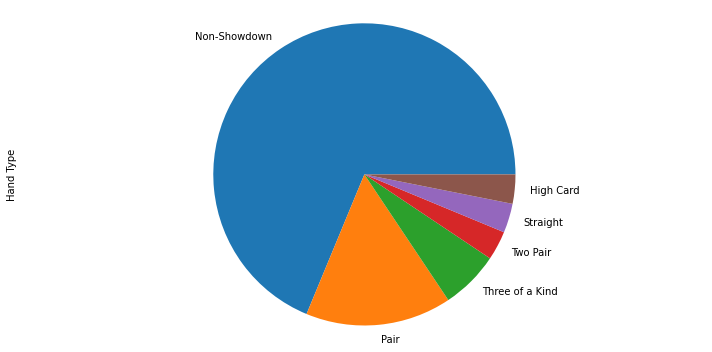

In [72]:
wins_df[(wins_df["Winner"]=="andy") ]["Hand Type"].value_counts().plot(kind="pie")
plt.axis('equal')

# wins_df["Hand Type"].value_counts().plot(kind="pie")
# plt.axis('equal')

Furthermore, we can generate the same analysis for every player, in order to see any interesting trends, similarities/differences between play styles, or affinity towards certain hands.

The final output can be an **individualized 1-Page Report** that each player can check at the end of every session, in order to gauge how they played.

In [77]:
# plt.rcParams["figure.figsize"] = (15,10)
plt.figure(figsize=(30,30))
g = sns.FacetGrid(wins_df), row = "Winner", col="Hand Type", size=4)
g = g.map(plt.plot, "Pot")

SyntaxError: cannot assign to function call (2748147654.py, line 3)

In [ ]:
# Output file name
plot_file_name="boxplot_and_swarmplot_with_seaborn.jpg"
 
# Save as jpeg
bplot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

## Further Ideas

This notebook is by no means done.

Some additional ideas that I have yet to explore include:
* Calculating traditional poker stats, such as VPIP, PFR, 3Bet% (VPIP = Voluntarily Put $ in Pot PFR = Pre-flop Raise)
* Aggregating logs from multiple sessions to gain more meaningful results, patterns, aggregate win/losses
* Putting together a printable Player Profile Report, that can be run for each player, complete with charts, stats etc.
* Predicting outcomes for each hand
* Looking more into effect of hand positions on win likelihood
* Correlation between Win Amounts & Win Quantity
* Quantifying likelihood to Bluff
* Quantifying bad run's / bad beats